In [96]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import imutils
from imutils import contours
import numpy as np

In [0]:
test_img_path='/content/drive/My Drive/Colab Notebooks/credit-card-detection/test-imgs/credit_card_01.png'
base_img_path='/content/drive/My Drive/Colab Notebooks/credit-card-detection/base_img.png'
output_path='/content/drive/My Drive/Colab Notebooks/credit-card-detection/output_01.png'

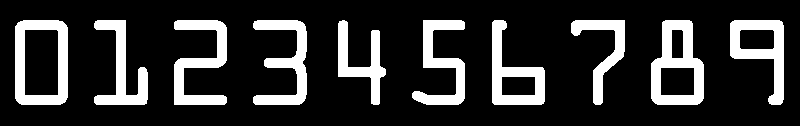

In [124]:
base= cv2.imread(base_img_path,0)
base= cv2.threshold(base, 20, 255, cv2.THRESH_BINARY_INV)[1]
cv2_imshow(base)

In [0]:
cnts = cv2.findContours(base.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts, method="left-to-right")[0]
digits={}

In [0]:
for (idx, cnt) in enumerate(cnts):
  (x, y, w, h) = cv2.boundingRect(cnt)
  roi = base[y:y + h, x:x + w]
  roi = cv2.resize(roi, (50, 70))
  digits[idx] = roi

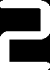

In [127]:
cv2_imshow(digits[2])

In [0]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

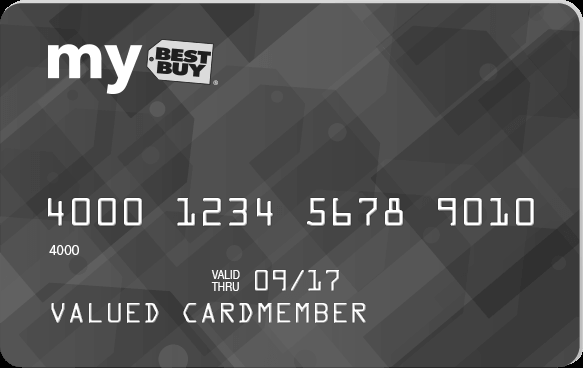

In [129]:
img = cv2.imread(test_img_path,0)
cv2_imshow(img)

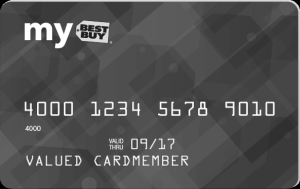

In [130]:
img = imutils.resize(img, width=300)
cv2_imshow(img)

In [0]:
tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, rectKernel)

In [0]:
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0,
	ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

In [0]:
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

In [0]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []

In [0]:
for (i, c) in enumerate(cnts):
	(x, y, w, h) = cv2.boundingRect(c)
	ar = w / float(h)
	if ar > 2.5 and ar < 4.0:
		if (w > 40 and w < 55) and (h > 10 and h < 20):
			locs.append((x, y, w, h))

In [0]:
locs = sorted(locs, key=lambda x:x[0])
output = []
for (i, (gX, gY, gW, gH)) in enumerate(locs):
  groupOutput = []
  group = img[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
  group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  digitCnts = imutils.grab_contours(digitCnts)
  digitCnts = contours.sort_contours(digitCnts,method="left-to-right")[0]

  for c in digitCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    roi = group[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88)) 
    scores = []
    for (digit, digitROI) in digits.items():
      result = cv2.matchTemplate(roi, digitROI,
        cv2.TM_CCOEFF)
      (_, score, _, _) = cv2.minMaxLoc(result)
      scores.append(score)
    groupOutput.append(str(np.argmax(scores)))


  cv2.rectangle(img, (gX - 5, gY - 5),(gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
  cv2.putText(img, "".join(groupOutput), (gX, gY - 15),cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
  output.extend(groupOutput)

Credit Card #: 4000123456789010


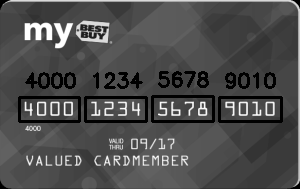

-1

In [137]:
print("Credit Card #: {}".format("".join(output)))
cv2_imshow( img)
cv2.waitKey(0)

In [141]:
cv2.imwrite(output_path,img)

True